Dataset Shape: (95923, 13)
  file_number       date_of_report           crime  reporting_area  \
0  2009-01323  2009-02-21 09:53:00         Threats             105   
1  2009-01324  2009-02-21 09:59:00      Auto Theft            1109   
2  2009-01327  2009-02-21 12:32:00     Hit And Run            1109   
3  2009-01331  2009-02-21 15:05:00  Larceny (Misc)            1303   
4  2009-01346  2009-02-22 05:02:00             Oui             105   

      neighborhood                           location     crime_start_time  \
0   East Cambridge         100 Otis St, Cambridge, Ma  2009-02-21 09:20:00   
1  North Cambridge      400 Rindge Ave, Cambridge, Ma  2009-02-20 22:30:00   
2  North Cambridge      400 Rindge Ave, Cambridge, Ma  2009-02-19 21:00:00   
3  Strawberry Hill      0 Norumbega St, Cambridge, Ma  2009-02-21 15:00:00   
4   East Cambridge  Fifth St & Gore St, Cambridge, Ma  2009-02-22 05:02:00   

   crime_year  crime_month  crime_day  crime_hour crime_dayofweek  \
0        2009 

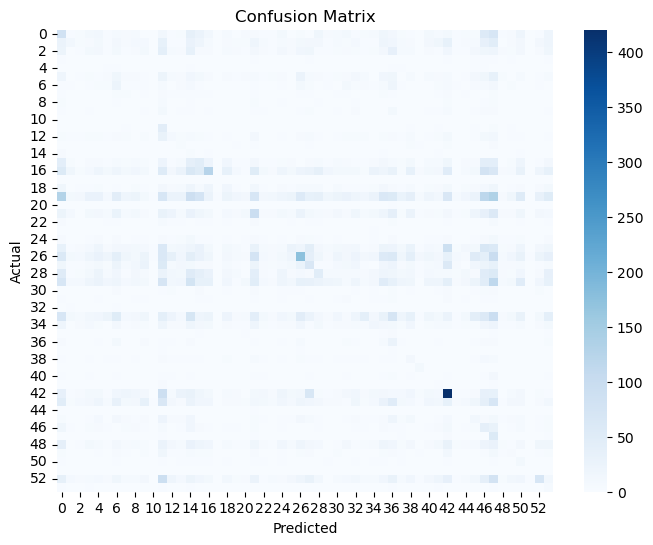

Model & Encoders Saved Successfully ✅


In [11]:
# =====================
# Crime Pattern Analysis & Prediction - ML Model
# =====================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib

# =====================
# Load Dataset
# =====================

data = pd.read_csv("../data/crimes.csv")

print("Dataset Shape:", data.shape)
print(data.head())

# =====================
# Encode Categorical Columns
# =====================

crime_encoder = LabelEncoder()
neigh_encoder = LabelEncoder()
day_encoder   = LabelEncoder()

data['crime_enc'] = crime_encoder.fit_transform(data['crime'])
data['neighborhood_enc'] = neigh_encoder.fit_transform(data['neighborhood'])
data['crime_dayofweek_enc'] = day_encoder.fit_transform(data['crime_dayofweek'])

print("Encoding Done")

# =====================
# Feature Selection
# =====================

X = data[['reporting_area','neighborhood_enc',
          'crime_year','crime_month',
          'crime_day','crime_hour',
          'crime_dayofweek_enc','is_night_crime']]

y = data['crime_enc']

print("X shape:", X.shape)
print("y shape:", y.shape)

# =====================
# Train-Test Split
# =====================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================
# Train Random Forest (Optimized)
# =====================

rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=12,
    min_samples_split=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("Model Training Completed")

# =====================
# Model Evaluation
# =====================

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Model Accuracy:", acc)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# =====================
# Confusion Matrix
# =====================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =====================
# Save Model & Encoders
# =====================

joblib.dump(rf_model, "crime_model.pkl")
joblib.dump(crime_encoder, "crime_encoder.pkl")
joblib.dump(neigh_encoder, "neigh_encoder.pkl")
joblib.dump(day_encoder, "day_encoder.pkl")

print("Model & Encoders Saved Successfully ✅")


In [14]:
import pandas as pd
import joblib

# Load model & encoders
model = joblib.load("../notebooks/crime_model.pkl")
crime_enc = joblib.load("../notebooks/crime_encoder.pkl")
neigh_enc = joblib.load("../notebooks/neigh_encoder.pkl")
day_enc   = joblib.load("../notebooks/day_encoder.pkl")

# Safe encoding function
def safe_encode(encoder, value):
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        return -1

# Sample input
sample = {
    "reporting_area": 808,
    "neighborhood": "ROXBURY",
    "crime_year": 2024,
    "crime_month": 2,
    "crime_day": 5,
    "crime_hour": 22,
    "crime_dayofweek": "Monday",
    "is_night_crime": 1
}

# Encode safely
sample["neighborhood_enc"] = safe_encode(neigh_enc, sample["neighborhood"])
sample["crime_dayofweek_enc"] = safe_encode(day_enc, sample["crime_dayofweek"])

# Build dataframe exactly like training
X_sample = pd.DataFrame([{
    "reporting_area": sample["reporting_area"],
    "neighborhood_enc": sample["neighborhood_enc"],
    "crime_year": sample["crime_year"],
    "crime_month": sample["crime_month"],
    "crime_day": sample["crime_day"],
    "crime_hour": sample["crime_hour"],
    "crime_dayofweek_enc": sample["crime_dayofweek_enc"],
    "is_night_crime": sample["is_night_crime"]
}])

# Predict
pred = model.predict(X_sample)
crime_label = crime_enc.inverse_transform(pred)

print("Predicted Crime Type:", crime_label[0])


Predicted Crime Type: Suspicious Package
